In [16]:
#@title
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73
    !pip install tqdm

import os
import random
import mat73
import scipy.io
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
from tensorflow.math import abs, angle, real, imag, subtract, multiply
from scipy.optimize import minimize
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tqdm import tqdm

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr  5 12:27:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
#@title
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape=[64,64]):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg
#http://edge.rit.edu/edge/P13051/public/Research%20Notes/refractive%20index%20glycerin%20water.pdf

In [18]:
def extract_pos_and_images(data):
    """Saves images and positions for individual particles."""
    particles_timeseries = []
    particles_positions = []
    num_particles = data.shape[1]

    for i in tqdm(range(num_particles)):
        positions = data[0,i][0,0]["Positions"][:,1:4]
        particles_positions.append(positions)
        roi_data = np.array(data[0,i][0,0]["ROI"])

        timeseries = []
        for j in range(roi_data[0,0].shape[0]):
            particleROI = np.expand_dims(np.fft.fftshift(np.fft.ifft2(exp_expand(roi_data[0,0][j,:], [64,64]))), axis = -1)
            timeseries.append(particleROI)
        particles_timeseries.append(np.array(timeseries))
    return particles_positions, particles_timeseries

In [19]:
"""Create group/equivariance"""


def create_group(crop_size=64, padding=16, wavelength=525e-9, pixel_size=114e-9):
    crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size, wavelength)
    crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size, wavelength)

    args = dt.Arguments(
        translate=lambda: np.random.randn(2)*0.5,
        rotate=lambda: np.random.uniform(0, np.pi*2),
        z=lambda: np.random.randn(1)*5,
    )

    group = ( 
        dt.Affine(rotate=args.rotate) 
        >> dt.Affine(translate=args.translate) 
        >> dt.FourierTransform(padding=padding) 
        >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z, padding=padding) 
        >> dt.InverseFourierTransform(padding=padding) 
    )

    equivariance = (
        dt.models.lodestar.Rotational2DEquivariance(args.rotate)
        >> dt.models.lodestar.TranslationalEquivariance(args.translate)
        >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
    )

    return group, equivariance

def create_training_set(particles_timeseries):
    imgs = []
    for particle_id in range(0,len(particles_timeseries),1):
        img = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        img = img[0,:,:,:]
        imgs.append(img)
    return dt.Value(lambda: random.choice(np.array(imgs)))

def plot_dataset(dataset, group, nrows=3, ncols=10):
    for _ in range(nrows):
        fig, axs = plt.subplots(1,ncols,figsize=(25,8))
        for i in range(ncols):
          axs[i].imshow((dataset>>group).update()()[..., 1])
        plt.show()


In [20]:
"""Create custom layers"""
class CustomLayer(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [21]:
"""Create models"""
def create_model(custom_layer, nlayers, image_size):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(image_size,image_size,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(64, 3, activation='relu', strides=(2,2)))
    for _ in range(nlayers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": nlayers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model


In [22]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = cycler(color=list('bgrcmyk'))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()


'\nfor _ in range(5):\n    with generator:\n        for model in models:\n            h = model.fit(generator, epochs=20, steps_per_epoch=100, verbose=0)\n            save_progress(model, h)\n        plot_progress(models)\n'

In [23]:
def save_models(model_list, save_model_path):
  for i, model in enumerate(model_list):
    model.save_weights(save_model_path + f"model{i}")

def load_models(path, num_models, image_size):
  model_list = []
  for i in range(num_models):
    model = create_model(CustomLayer(), 2, image_size)
    model.load_weights(path + f"model{i}")
    model_list.append(model)

  return model_list

In [25]:
def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets, val_stack.shape[2])
    return dets

def reshape_dets(dets, image_size):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = image_size//2, image_size//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

"""
def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]
"""

In [26]:
def calc_sigma2(arr):
    sigma2 = -np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            ))
    return sigma2

In [27]:
def train_on_particle(model, particle):
    training_set = create_training_set(particle)

    generator = dt.models.lodestar.LodeSTARGenerator(
        training_set,
        num_outputs=num_outputs, 
        transformation_function=(group, equivariance), 
        batch_size=8, 
        min_data_size=100, 
        max_data_size=101,
    )

    for _ in tqdm(range(10)):
        with generator:
            h = model.fit(generator, epochs=10, steps_per_epoch=100, verbose=0)

def compare_lode_matlab(model, particles, verbose=1):
    z_mults = []
    traces_matlab = []
    traces_lode = []

    for particle_id in tqdm(range(len(particles))):

        timeseries = np.stack((np.real(particles[particle_id][:,:,:,0]), np.imag(particles[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(model, timeseries)

        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], 1.5*particles_positions[particle_id][:,2]

        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(x_lode-32)*0.114, y_matlab+(y_lode-32)*0.114, z_matlab+z_lode

        z_mult = minimize(lambda x: np.abs(calc_sigma2(z_matlab + z_lode*x)), [0], method="Powell").x
        z_mult = np.median([-10,z_mult,10]) #reducing the effect of very strange values

        if verbose:
            print("PARTICLE ID:", particle_id, end="  ")
            print(f"z_mult: {z_mult:.3f}, sigma2_new/sigma2_matlab: {calc_sigma2(z_new)/calc_sigma2(z_matlab):.2f}")

            if particle_id%10==0:
                fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
                ax1.plot(x_matlab, 'b')
                ax1.plot(x_new, 'r')
                ax1.set_xlabel("x")

                ax2.plot(y_matlab, 'b')
                ax2.plot(y_new, 'r')
                ax2.set_xlabel("y")

                ax3.plot(z_matlab, 'b')
                ax3.plot(z_new, 'r')
                ax3.set_xlabel("z")
                plt.show()

        z_mults.append(z_mult)
        traces_matlab.append(np.array([x_matlab, y_matlab, z_matlab]))
        traces_lode.append(np.array([x_lode*0.114, y_lode*0.114, z_lode]))

    return traces_matlab, traces_lode, z_mults

In [28]:
def plot_diffusion(Dx, Dz, colors, title):
    range=(-2,6)
    nbins=25
    plt.figure(figsize=(5, 4))

    plt.hist(Dx, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[0]], label="In-plane diffusion")
    plt.hist(Dz, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[1]], label="Vertical diffusion")
    
    plt.axvline(np.median(Dx), c=seaborn.color_palette("colorblind")[colors[0]], linestyle="--", label="Median")
    plt.axvline(np.median(Dz), c=seaborn.color_palette("colorblind")[colors[1]], linestyle="--", label="Median")
    plt.title(title)
    plt.legend()
    plt.show()
    print(f"nz/nx = sqrt(Dz/Dx) {np.sqrt(np.median(Dz)/np.median(Dx)):.3f}")

def calculate_diffusion(traces, shortest_trace=20):
    _traces = [trace for trace in traces if trace.shape[1]>shortest_trace]

    #Ekvation 16
    sigma_x2 = np.array([calc_sigma2(trace[0,:]) for trace in _traces])
    sigma_z2 = np.array([calc_sigma2(trace[2,:]) for trace in _traces])

    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*sigma_x2[i])
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*sigma_z2[i])
          /(2*delta_time)
          )
    plot_diffusion(D_x, D_z, (9,3), "Ekvation 16, Separata skattningar för sigma")

    #Ekvation 16 (medelvärdet av sigma)
    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*np.median(sigma_x2))
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*np.median(sigma_z2))
          /(2*delta_time)
          )
    plot_diffusion(D_x, D_z, (9,3), "Ekvation 16, Medelvärdet av alla sigma")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading file: 0wtGlycerol_300nmSilica_NoGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 1409/1409 [00:52<00:00, 26.90it/s]


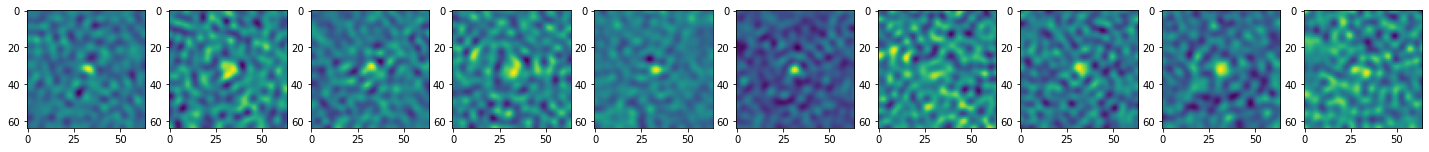

  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:48<07:15, 48.36s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:00<03:34, 26.76s/it]

Generating 101 / 100 samples before starting training


 30%|███       | 3/10 [01:11<02:17, 19.60s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:22<01:38, 16.34s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [01:34<01:13, 14.70s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [01:45<00:53, 13.48s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [01:56<00:38, 12.77s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [02:08<00:24, 12.35s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [02:20<00:12, 12.23s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [02:31<00:00, 15.15s/it]


Creating corrected traces 

  3%|▎         | 48/1409 [00:06<03:05,  7.33it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
100%|██████████| 1409/1409 [03:15<00:00,  7.20it/s]


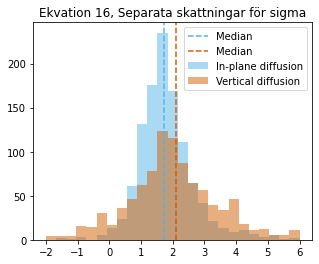

nz/nx = sqrt(Dz/Dx) 1.102


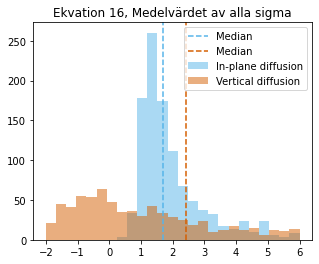

nz/nx = sqrt(Dz/Dx) 1.198
Loading file: 0wtGlycerol_300nmSilica_NoGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat 

100%|██████████| 35/35 [00:01<00:00, 27.17it/s]


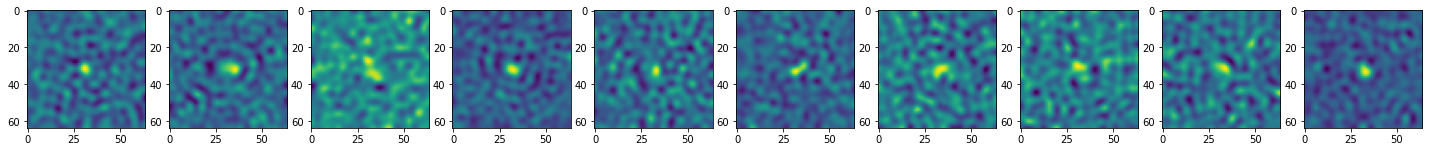

  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:22<03:26, 22.96s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [00:35<02:12, 16.62s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [00:46<01:40, 14.42s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [00:58<01:20, 13.46s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [01:10<01:04, 12.82s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [01:22<00:49, 12.47s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [01:34<00:37, 12.39s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [01:46<00:24, 12.28s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [01:58<00:12, 12.16s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Creating corrected traces 

100%|██████████| 35/35 [00:04<00:00,  7.30it/s]


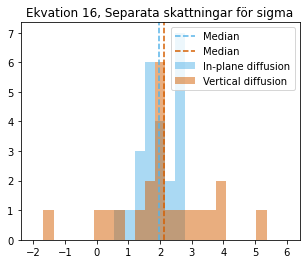

nz/nx = sqrt(Dz/Dx) 1.045


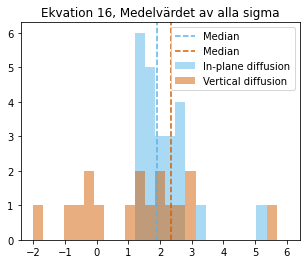

nz/nx = sqrt(Dz/Dx) 1.109
Loading file: 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 1308/1308 [00:51<00:00, 25.23it/s]


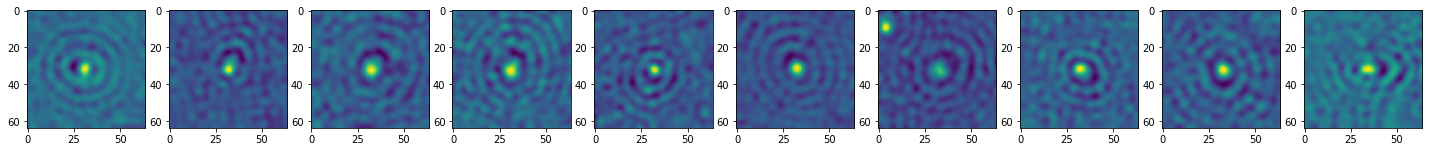

  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:28<04:15, 28.36s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [00:39<02:26, 18.27s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [00:50<01:45, 15.08s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:02<01:22, 13.70s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [01:14<01:05, 13.14s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [01:26<00:50, 12.62s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [01:37<00:36, 12.23s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [01:49<00:24, 12.02s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [02:01<00:12, 12.06s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [02:13<00:00, 13.33s/it]


Creating corrected traces 

100%|██████████| 1308/1308 [03:12<00:00,  6.80it/s]


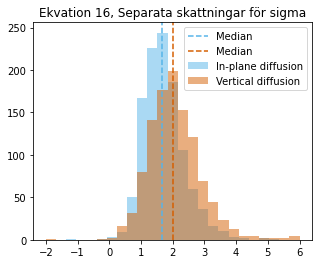

nz/nx = sqrt(Dz/Dx) 1.100


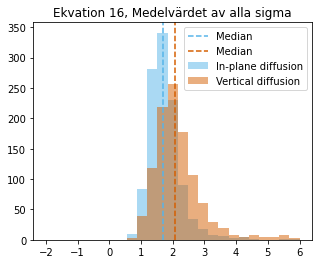

nz/nx = sqrt(Dz/Dx) 1.110
Loading file: 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat 

100%|██████████| 239/239 [00:09<00:00, 24.41it/s]


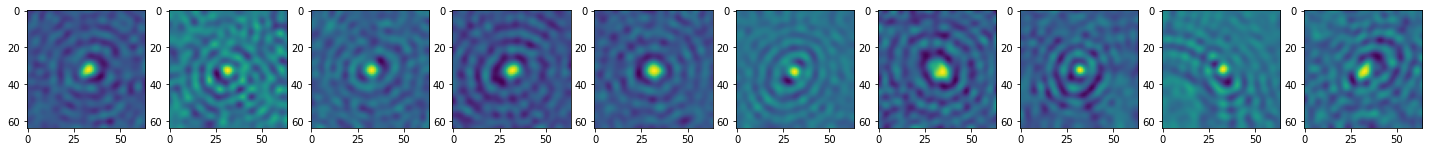

  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:23<03:32, 23.64s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [00:36<02:19, 17.45s/it]

Generating 101 / 100 samples before starting training


 30%|███       | 3/10 [00:48<01:44, 14.91s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:00<01:21, 13.65s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [01:12<01:05, 13.06s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [01:24<00:51, 12.84s/it]

Generating 101 / 100 samples before starting training


 70%|███████   | 7/10 [01:36<00:37, 12.58s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [01:49<00:25, 12.59s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [02:00<00:12, 12.20s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [02:12<00:00, 13.28s/it]


Creating corrected traces 

100%|██████████| 239/239 [00:36<00:00,  6.56it/s]


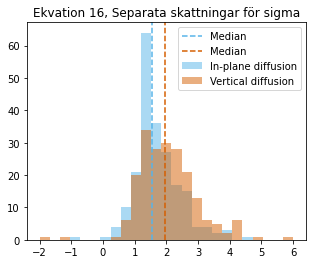

nz/nx = sqrt(Dz/Dx) 1.123


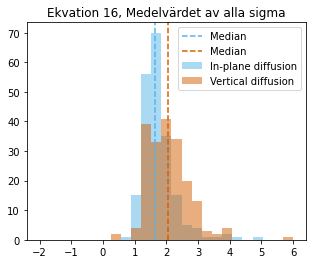

nz/nx = sqrt(Dz/Dx) 1.117
Loading file: 25wtGlycerol_300nmSilica_NoGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat 

100%|██████████| 1209/1209 [00:34<00:00, 34.58it/s]


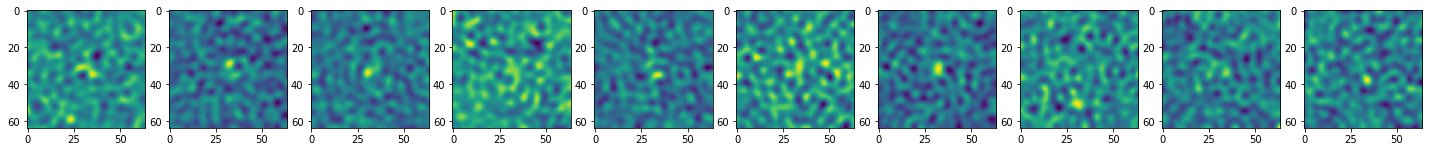

  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:28<04:15, 28.40s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [00:39<02:27, 18.38s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [00:51<01:47, 15.40s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:03<01:23, 13.85s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [01:14<01:05, 13.12s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [01:26<00:50, 12.55s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [01:37<00:36, 12.19s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [01:49<00:24, 12.02s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [02:00<00:11, 11.81s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [02:12<00:00, 13.25s/it]


Creating corrected traces 

100%|██████████| 1209/1209 [02:22<00:00,  8.46it/s]


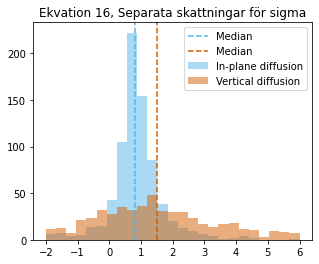

nz/nx = sqrt(Dz/Dx) 1.366


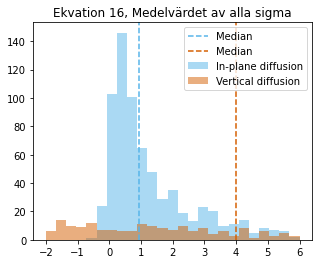

nz/nx = sqrt(Dz/Dx) 2.058
Loading file: 25wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

 91%|█████████▏| 954/1045 [00:50<00:05, 15.67it/s]

In [ ]:
crop_size = 64
padding = 16
wavelength = 525e-9
pixel_size = 114e-9
num_outputs=3
image_size=64
delta_time = 1/41
num_layers = 2

drive.mount('/content/drive')
filenames = !ls 'drive/My Drive/ny data från Erik'
filenames = [filename for filename in filenames if ".mat" in filename]

model = create_model(CustomLayer(), num_layers, image_size)

for filename in filenames: #filenames:
    file_path = "/content/drive/My Drive/ny data från Erik/" + filename
    data = scipy.io.loadmat(file_path)['CompletedTraces']
    print(f"Loading file: {filename}", end=" ")
    particles_positions, particles_timeseries = extract_pos_and_images(data)

    group, equivariance = create_group(crop_size=crop_size, padding=padding, wavelength=wavelength, pixel_size=114e-9)
    plot_dataset(create_training_set(particles_timeseries), group, nrows=1)
    train_on_particle(model, particles_timeseries)
    print(f"Creating corrected traces", end=" ")
    traces_matlab, traces_lode, z_mults = compare_lode_matlab(model, particles_timeseries, verbose=0)
    calculate_diffusion([x[0]+x[1] for x in zip(traces_matlab, traces_lode)])